<a href="https://colab.research.google.com/github/vinayak19th/QuickDrawGAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
 awards1.pdf			'MAC OS'
 CertificateL.psd		'macOS High Sierra Final (One Full)'
 Colab				 model_weights.h5
'Colab Notebooks'		'Ranjini Ramesh Resume.pdf'
'Document from Vinayak Sharma'	'West World William.jpg'
 DS


In [0]:
import sys
sys.path.append("drive/Colab/GANS/")
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', 'drive/Colab/GANS/', 'drive/Colab/GANS/']


# Quick Draw GAN

A Generative Adversarial Network trained of the Google Quickdraw dataset found here: https://github.com/googlecreativelab/quickdraw-dataset#preprocessed-dataset

Created in tf.keras

In [0]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

In [0]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation,Reshape
from tensorflow.keras.layers import BatchNormalization, Conv2D,Flatten, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard

In [0]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import Adam

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
tf.__version__

NameError: ignored

## Helper Functions

In [0]:
def imshow(image,n):
    return plt.imshow(image[n,:,:,0],cmap='Greys')


def get_np(inp_path):
    data = np.load(inp_path)
    data = data/255
    data = data.reshape(data.shape[0],28,28,1)
    return data


def get_callbacks():
    from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
    from time import time
    checkpoint = ModelCheckpoint("output/", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    tboard = TensorBoard(log_dir="output/logs/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)
    return [checkpoint,tboard]


## Load the Data

In [0]:
inp_path = 'drive/Colab/GANS/full_numpy_bitmap_apple.npy'
data = get_np(inp_path)
img_w,img_h = data.shape[1:3]

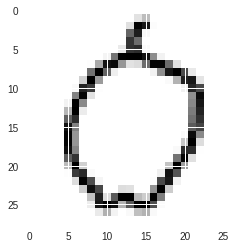

In [0]:
imshow(data,1040)

In [0]:
data.shape

(144722, 28, 28, 1)

# Discriminator

In [0]:
def discriminator_builder(width = 64,p=0.4):
    #Inputs
    inputs=  Input((img_w,img_h,1))
    
    #Model Layers
    conv1 = Conv2D(width*1,5,strides=2,padding='same',activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2,5,strides=2,padding='same',activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4,5,strides=2,padding='same',activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8,5,strides=1,padding='same',activation='relu')(conv3)
    conv4 = Dropout(p)(conv4)
    conv4 = Flatten()(conv4)
    
    output = Dense(1,activation='sigmoid')(conv4)
    
    #Model Definiton
    discriminator = Model(inputs,output)
    discriminator.summary()
    return discriminator

In [0]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 256)         0         
__________

In [0]:
discriminator.compile(loss='binary_crossentropy', 
                    optimizer=Adam(lr=0.0008, decay=6e-8, clipvalue=1.0),
                      metrics=['accuracy'])

# Generator

In [0]:
def generator_builder(z_dims = 100,depth = 64,p = 0.4):
    #inputs
    inputs = Input((z_dims,))
    
    #Dense
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation('relu')(dense1)
    
    #Reshape to (7,7,64) tensor
    reshaper = Reshape((7,7,64))(dense1)
    #reshaper = BatchNormalization()(reshaper)
    reshaper = Dropout(p)(reshaper)
    
    #Deconvoliutions
    deconv1 = UpSampling2D()(reshaper)
    deconv1 = Conv2DTranspose(int(depth/2),kernel_size=5,padding='same')(deconv1)
    deconv1 = BatchNormalization(momentum=0.9)(deconv1)
    deconv1 = Activation('relu')(deconv1)
    
    deconv2 = UpSampling2D()(deconv1)
    deconv2 = Conv2DTranspose(int(depth/4),kernel_size=5,padding='same')(deconv2)
    deconv2 = BatchNormalization(momentum=0.9)(deconv2)
    deconv2 = Activation('relu')(deconv2)
    
    deconv3 = Conv2DTranspose(int(depth/8),kernel_size=5,padding='same')(deconv2)
    deconv3 = BatchNormalization(momentum=0.9)(deconv3)
    deconv3 = Activation('relu')(deconv3)
    
    #Output
    output = Conv2D(1,kernel_size=5,padding='same',activation='sigmoid')(deconv3)
    model = Model(inputs,output)
    model.summary()
    return model

In [0]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_5 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_5 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 64)        0         
__________

# GAN

In [0]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

In [0]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_2 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [0]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

In [0]:
a_metrics, d_metrics = train()

0
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100


KeyboardInterrupt: ignored

In [0]:
from keras.utils import plot_model
plot_model(adversarial_model,to_file='drive/Colab/GANS/GAN.png',show_shapes=True,rankdir='LR')

In [0]:
noise = np.random.uniform(-1.0, 1.0, size=[5, 100])
x = generator.predict(noise,batch_size=1,verbose = 1)

In [0]:
type(x)

In [0]:
x.shape

In [0]:
y = discriminator.predict(x)

In [0]:
y

In [0]:
adversarial_model.predict(noise)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from time import time
checkpoint = ModelCheckpoint("output/", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tboard = TensorBoard(log_dir="output/logs/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)
[checkpoint,tboard]